In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

from lpproj import LocalityPreservingProjection

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.pipeline import Pipeline
import pickle

# Exoplanet Transit Classification (Kepler Mission)
## Data Preprocessing

In [ ]:
### X|y split + training and hold-out dataset creation

In [2]:
feature_df_path = "..\\data\\feat_df_tot.csv"

df_exo = pd.read_csv(feature_df_path, index_col = ['KIC_ID', 'TCE_num'])
cols_to_drop = ["time_complexity", "Depth", "rms"]
df_exo = df_exo.drop(columns = cols_to_drop)
df_exo.head(3)

,,Period,Duration,target_label,even_odd_stat,p_secondary,max,min,LCBIN_0,LCBIN_1,LCBIN_2,...,LCBIN_131,LCBIN_132,LCBIN_133,LCBIN_134,LCBIN_135,LCBIN_136,LCBIN_137,LCBIN_138,LCBIN_139,LCBIN_140
KIC_ID,TCE_num,,,,,,,,,,,,,,,,,,,,,
757450,1,8.884923,2.07004,1,0.925362,0.007862,0.000177,-0.015739,-0.003788,-0.002984,-0.002181,...,0.003811,0.003485,0.004310,0.005135,0.005959,0.006784,0.007609,0.008434,0.009258,0.010083
1026032,1,8.460439,4.73492,2,0.978880,0.000000,0.000360,-0.077604,0.001511,0.001346,0.001181,...,0.001283,0.001274,0.001265,0.001134,0.001003,0.000872,0.000741,0.000870,0.000999,0.001129
1293031,1,0.539366,5.43400,3,0.499758,0.289257,0.000026,-0.000017,-1.000000,-0.979731,-0.959462,...,0.417232,0.435126,0.453019,0.470913,0.488807,0.506700,0.524594,0.542487,0.560381,0.578274


In [3]:
# define X and y
X = df_exo.drop(columns = ['target_label'])
y = df_exo['target_label']

#now create train + hold out set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, stratify = y)

In [5]:
y_test.value_counts()

1    351
2    321
3    132
Name: target_label, dtype: int64

In [6]:
y_train.value_counts()

1    1983
2    1819
3     749
Name: target_label, dtype: int64

In [7]:
# At this point, X_train, y_train, x_test, y_test will be saved as separate files. That way the modeling is being evaluated from a particular train/test sample as saved on file.

base_path = "..\\data\\"
datasplit_dict = {"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test}

for name, data in datasplit_dict.items():
    data.to_csv(base_path + name + ".csv")


### Data preprocessing on train/hold-out test data from file

In [26]:
# load X_train from file
X_train = pd.read_csv(base_path + 'X_train.csv', index_col=['KIC_ID', 'TCE_num'] )

In [39]:
#transformer class to perform sqrt log transform on p_secondary and even_odd_stat

class SqrtLogZeroExceptionTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        super().__init__()
        self.trans_evenodd_max_ = None
        self.trans_psec_max_ = None

    def fit(self, X, y = None):
        cols_to_take = ['even_odd_stat', 'p_secondary'] #these are the columns for which we'll do the sqrt log transformation

        with np.errstate(divide='ignore'):
            X_trans = np.sqrt(np.abs(np.log10(X[cols_to_take])))
        # cuts out infinities and gets maxes --> will use this to impute infinities (which are zeros in the original feature set)
        maxsqrtlog = X_trans[~(X_trans == np.inf)].max()

        self.trans_evenodd_max_ = maxsqrtlog['even_odd_stat']
        self.trans_psec_max_ = maxsqrtlog['p_secondary']

        return self
    
    def transform(self, X, y = None):
        cols_to_take = ['even_odd_stat', 'p_secondary'] #these are the columns for which we'll do the sqrt log transformation

        # this will issue some divide by zero warnings. im going to suppress this warning.
        with np.errstate(divide='ignore'):
            X_trans = np.sqrt(np.abs(np.log10(X[cols_to_take])))


        X_toreturn = deepcopy(X)
        X_toreturn['even_odd_stat'] = X_trans['even_odd_stat'].replace(np.inf, self.trans_evenodd_max_)
        X_toreturn['p_secondary'] = X_trans['p_secondary'].replace(np.inf, self.trans_psec_max_)

        return X_toreturn

    def fit_transform(self, X, y = None):
        return self.fit(X).transform(X)

#### Set up column transformer for LPP dim reduction on LCBIN data and then construct transformation pipeline

In [40]:
# transformer class to do the LPP dimensional reduction on the LCBIN subset.
#  the columntransformer only performs LPP on the 141 LCBIN features.

LCBINselector = make_column_selector(pattern = "^LCBIN_")
trans = [('lpp', LocalityPreservingProjection(n_components=2), LCBINselector(X_train) )]

# pipeline first sqrt log transforms secondary peak detection features, then dim reduction on LCBIN, then min/max scaling
steps = [('sqrtlog', SqrtLogZeroExceptionTransformer()), ('lpptrans', ColumnTransformer(transformers = trans, remainder = 'passthrough') ), ('scaler', MinMaxScaler() )]

# fit_transforming the pipeline will output a numpy array (LocalityPreservingProjection outputs numpy array). 
# column order is (LPP_1, LPP_2, Period, Duration, even_odd_stat, p_secondary, max, min)

datatrans_pipe = Pipeline(steps)

In [41]:
datatrans_pipe.fit(X_train)

Pipeline(steps=[('sqrtlog', SqrtLogZeroExceptionTransformer()),
                ('lpptrans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('lpp',
                                                  LocalityPreservingProjection(),
                                                  ['LCBIN_0', 'LCBIN_1',
                                                   'LCBIN_2', 'LCBIN_3',
                                                   'LCBIN_4', 'LCBIN_5',
                                                   'LCBIN_6', 'LCBIN_7',
                                                   'LCBIN_8', 'LCBIN_9',
                                                   'LCBIN_10', 'LCBIN_11',
                                                   'LCBIN_12', 'LCBIN_13',
                                                   'LCBIN_14', 'LCBIN_15',
                                                   'LCBIN_16', 'LCBIN_17',
                                           

#### Before we pickle our preprocessing want to take a look at how the features to see if anything bad happened.

In [42]:
colnames = ['LPP_1', 'LPP_2', 'Period', 'Duration', 'even_odd_stat', 'p_secondary', 'max', 'min']
normXtrain_df = pd.DataFrame(datatrans_pipe.transform(X_train), columns = colnames, index = X_train.index)

In [43]:
normXtrain_df.head()

,,LPP_1,LPP_2,Period,Duration,even_odd_stat,p_secondary,max,min
KIC_ID,TCE_num,,,,,,,,
11853878,3,0.116384,0.550926,0.005045,0.010961,0.026884,0.077648,0.047251,0.999346
5023956,1,0.139907,0.514373,0.001417,0.029789,0.054665,0.044576,0.047250,0.994060
5471289,1,0.117161,0.480827,0.011316,0.209957,0.045819,0.174549,0.047411,0.999625
11074835,1,0.100394,0.530287,0.005347,0.071834,0.012020,0.101134,0.047213,0.999860
10471515,1,0.128217,0.509105,0.003247,0.020366,0.016189,0.070594,0.047154,0.999927


In [44]:
normXtrain_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4551 entries, (11853878, 3) to (12356914, 1)
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LPP_1          4551 non-null   float64
 1   LPP_2          4551 non-null   float64
 2   Period         4551 non-null   float64
 3   Duration       4551 non-null   float64
 4   even_odd_stat  4551 non-null   float64
 5   p_secondary    4551 non-null   float64
 6   max            4551 non-null   float64
 7   min            4551 non-null   float64
dtypes: float64(8)
memory usage: 649.5 KB


Good, no NaNs. The standard describe statistics are not useful for our features. Let's just do some quick visualization to check if the distributions look the same as when we did the EDA.

<AxesSubplot:xlabel='LPP_1', ylabel='LPP_2'>

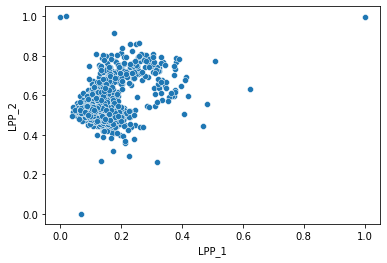

In [45]:
sns.scatterplot(x = 'LPP_1', y = 'LPP_2', data = normXtrain_df)

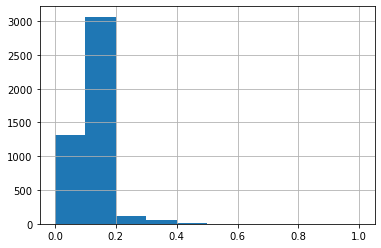

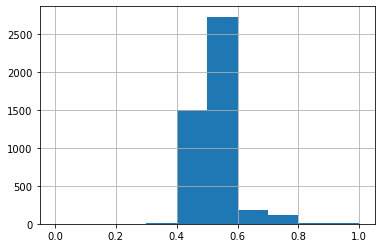

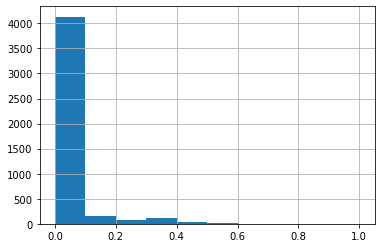

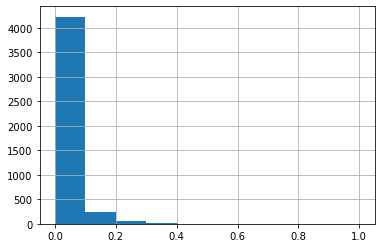

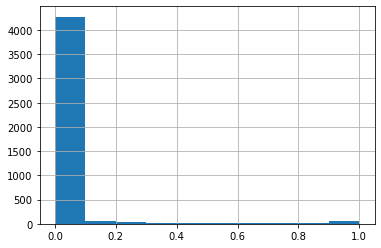

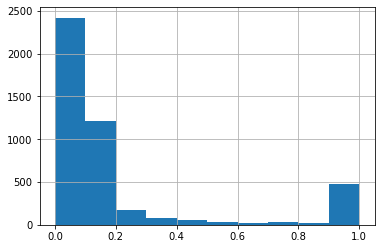

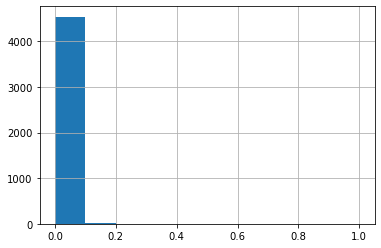

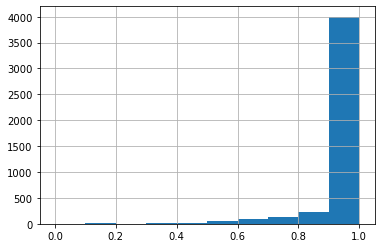

In [46]:
for col in normXtrain_df.columns:
    normXtrain_df[col].hist()
    plt.show()


Looks 

#### Pickle data transformation pipeline for later use

In [47]:
preprocess_object_path = "..\\models\\preprocessing\\preprocess_pipeline.pkl"
pickle.dump(datatrans_pipe, open(preprocess_object_path, 'wb'))